# 1. Setup

In [1]:
!pip install -r requirements.txt

## 1.1 Imports

In [2]:
# my gereneral imports
import os
import wget
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
import time
# url data reader imports
from bs4 import BeautifulSoup
import requests
# pyspark imports
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql.types import StructType, StructField, DoubleType, IntegerType, StringType
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, OneHotEncoder, MinMaxScaler, VectorAssembler
from pyspark.ml.classification import GBTClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

%matplotlib inline

PROJECT_ROOT_DIR = "."
DATA_PATH = os.path.join(PROJECT_ROOT_DIR, "data")
os.makedirs(DATA_PATH, exist_ok=True)
OUT_PATH = os.path.join(PROJECT_ROOT_DIR, "output")
os.makedirs(OUT_PATH, exist_ok=True)

t0 = time.time()

# Q1. PySpark Assessment

## 1.1 Setup a local environment to run PySpark

Create Spark session

In [3]:
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))
spark = SparkSession \
    .builder \
    .getOrCreate()

## 1.2 Downloading data

In [4]:
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/census-income-mld/"
ext = 'gz'

def list_files(url, ext=''):
    page = requests.get(url).text
#     print(page)
    soup = BeautifulSoup(page, 'html.parser')
    return [url + node.get('href') for node in soup.find_all('a') if node.get('href').endswith(ext)]

for fileurl in list_files(url, ext):
#     print(fileurl)
    filename = fileurl.split('/')[-1]
#     print(filename)
    wget.download(fileurl, out=os.path.join(DATA_PATH, filename))

100% [..........................................................................] 9789310 / 9789310

In [5]:
os.listdir('data')

['census-income.data (1).gz',
 'census-income.data.gz',
 'census-income.test (1).gz',
 'census-income.test.gz',
 'census.tar (1).gz',
 'census.tar.gz']

### 1.2.1 Read the data

In [6]:
df = (
    spark.read.format("csv").\
    options(header='false', inferSchema='True').\
    load(os.path.join(DATA_PATH, 'census-income.data.gz'))
)

In [7]:
df.show(1)

+---+----------------+---+---+--------------------+---+----------------+--------+--------------------+----------------+------+----------+-------+----------------+----------------+-------------------+----+----+----+---------+----------------+----------------+--------------------+--------------------+-------+----+----+----+--------------------+----+----+----------------+--------------+--------------+--------------+--------------------+----+----------------+----+----+----+---------+
|_c0|             _c1|_c2|_c3|                 _c4|_c5|             _c6|     _c7|                 _c8|             _c9|  _c10|      _c11|   _c12|            _c13|            _c14|               _c15|_c16|_c17|_c18|     _c19|            _c20|            _c21|                _c22|                _c23|   _c24|_c25|_c26|_c27|                _c28|_c29|_c30|            _c31|          _c32|          _c33|          _c34|                _c35|_c36|            _c37|_c38|_c39|_c40|     _c41|
+---+----------------+---+---+

### 1.2.2. Make correct column names

I could not find where to get column names easily...
The `census-income.names` file reports that there should be 40 columns (0-39) and we have 42 (0-41).
The first column is clearly the age.
The last column in the dataset is a dummy variable for income below or above 50 000.
The second-to-last column is clearly the year.
Therefore, there must be an extra column in among `_c1`--`_c39` that is not listed in the `census-income.names` file...

I was able to identify that variable by comparing the variables descriptions and the column values in the cell output above.
**This might not be possible if you have hundreds or thousands of features.**
The 'extra' column is `_c24` which is continuous. I suspect it is an income variable.
I made a dictionary below for the correct column names.

In [8]:
correct_columns = {
    "_c0": "age",
    "_c1": "class_of_worker",
    "_c2": "detailed_industry_recode",
    "_c3": "detailed_occupation_recode",
    "_c4": "education",
    "_c5": "wage_per_hour",
    "_c6": "enroll_in_edu_inst_last_wk",
    "_c7": "marital_stat",
    "_c8": "major_industry_code",
    "_c9": "major_occupation_code",
    "_c10": "race",
    "_c11": "hispanic_origin",
    "_c12": "sex",
    "_c13": "member_of_a_labor_union",
    "_c14": "reason_for_unemployment",
    "_c15": "full_or_part_time_employment_stat",
    "_c16": "capital_gains",
    "_c17": "capital_losses",
    "_c18": "dividends_from_stocks",
    "_c19": "tax_filer_stat",
    "_c20": "region_of_previous_residence",
    "_c21": "state_of_previous_residence",
    "_c22": "detailed_household_and_family_stat",
    "_c23": "detailed_household_summary_in_household",
    "_c24": "UNKNOWN_VARIABLE",
    "_c25": "migration_code-change_in_msa",
    "_c26": "migration_code-change_in_reg",
    "_c27": "migration_code-move_within_reg",
    "_c28": "live_in_this_house_1_year_ago",
    "_c29": "migration_prev_res_in_sunbelt",
    "_c30": "num_persons_worked_for_employer",
    "_c31": "family_members_under_18",
    "_c32": "country_of_birth_father",
    "_c33": "country_of_birth_mother",
    "_c34": "country_of_birth_self",
    "_c35": "citizenship",
    "_c36": "own_business_or_self_employed",
    "_c37": "fill_inc_questionnaire_for_veterans_admin",
    "_c38": "veterans_benefits",
    "_c39": "weeks_worked_in_year",
    "_c40": "year",
    "_c41": "income_binary",
}

In [9]:
my_cols = [val for val in correct_columns.values()]

In [10]:
df = (
    spark.read.format("csv").\
    options(header='false', inferSchema='True').\
    load(os.path.join(DATA_PATH, 'census-income.data.gz')).\
    toDF(*my_cols)
)

## 1.3 Print the data Schema, Summary, # of columns and # of rows

Print schema

In [11]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- class_of_worker: string (nullable = true)
 |-- detailed_industry_recode: double (nullable = true)
 |-- detailed_occupation_recode: double (nullable = true)
 |-- education: string (nullable = true)
 |-- wage_per_hour: double (nullable = true)
 |-- enroll_in_edu_inst_last_wk: string (nullable = true)
 |-- marital_stat: string (nullable = true)
 |-- major_industry_code: string (nullable = true)
 |-- major_occupation_code: string (nullable = true)
 |-- race: string (nullable = true)
 |-- hispanic_origin: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- member_of_a_labor_union: string (nullable = true)
 |-- reason_for_unemployment: string (nullable = true)
 |-- full_or_part_time_employment_stat: string (nullable = true)
 |-- capital_gains: double (nullable = true)
 |-- capital_losses: double (nullable = true)
 |-- dividends_from_stocks: double (nullable = true)
 |-- tax_filer_stat: string (nullable = true)
 |-- region_of_previous

Print summary

In [12]:
df.summary()

DataFrame[summary: string, age: string, class_of_worker: string, detailed_industry_recode: string, detailed_occupation_recode: string, education: string, wage_per_hour: string, enroll_in_edu_inst_last_wk: string, marital_stat: string, major_industry_code: string, major_occupation_code: string, race: string, hispanic_origin: string, sex: string, member_of_a_labor_union: string, reason_for_unemployment: string, full_or_part_time_employment_stat: string, capital_gains: string, capital_losses: string, dividends_from_stocks: string, tax_filer_stat: string, region_of_previous_residence: string, state_of_previous_residence: string, detailed_household_and_family_stat: string, detailed_household_summary_in_household: string, UNKNOWN_VARIABLE: string, migration_code-change_in_msa: string, migration_code-change_in_reg: string, migration_code-move_within_reg: string, live_in_this_house_1_year_ago: string, migration_prev_res_in_sunbelt: string, num_persons_worked_for_employer: string, family_member

Print # of rows

In [13]:
print(f"Number of rows: {df.count()}")

Number of rows: 199523


Print # of columns

In [14]:
print(f"Number of columns: {len(df.columns)}")

Number of columns: 42


## 1.4 Print a table that shows distinct values of all columns

**This task as it is written in the doc file seems rather stupid as we have continuous variables.**

In [15]:
df.columns

['age',
 'class_of_worker',
 'detailed_industry_recode',
 'detailed_occupation_recode',
 'education',
 'wage_per_hour',
 'enroll_in_edu_inst_last_wk',
 'marital_stat',
 'major_industry_code',
 'major_occupation_code',
 'race',
 'hispanic_origin',
 'sex',
 'member_of_a_labor_union',
 'reason_for_unemployment',
 'full_or_part_time_employment_stat',
 'capital_gains',
 'capital_losses',
 'dividends_from_stocks',
 'tax_filer_stat',
 'region_of_previous_residence',
 'state_of_previous_residence',
 'detailed_household_and_family_stat',
 'detailed_household_summary_in_household',
 'UNKNOWN_VARIABLE',
 'migration_code-change_in_msa',
 'migration_code-change_in_reg',
 'migration_code-move_within_reg',
 'live_in_this_house_1_year_ago',
 'migration_prev_res_in_sunbelt',
 'num_persons_worked_for_employer',
 'family_members_under_18',
 'country_of_birth_father',
 'country_of_birth_mother',
 'country_of_birth_self',
 'citizenship',
 'own_business_or_self_employed',
 'fill_inc_questionnaire_for_vetera

In [16]:
tab_distinct = []
for c in df.columns:
    tab_distinct.append([i[c] for i in df.select(c).distinct().collect()])

In [17]:
df_distinct = pd.DataFrame(tab_distinct).transpose().dropna(axis=0, how='all')
df_distinct.columns = df.columns

In [18]:
display(df_distinct)

,age,class_of_worker,detailed_industry_recode,detailed_occupation_recode,education,wage_per_hour,enroll_in_edu_inst_last_wk,marital_stat,major_industry_code,major_occupation_code,...,country_of_birth_father,country_of_birth_mother,country_of_birth_self,citizenship,own_business_or_self_employed,fill_inc_questionnaire_for_veterans_admin,veterans_benefits,weeks_worked_in_year,year,income_binary
0,31,Never worked,8,8,10th grade,692,College or university,Widowed,Medical except hospital,Adm support including clerical,...,Dominican-Republic,Dominican-Republic,Dominican-Republic,Foreign born- Not a citizen of U S,0,Yes,0,8,94,- 50000.
1,85,State government,0,0,Some college but no degree,769,High school,Married-A F spouse present,Not in universe or children,Private household services,...,Ireland,Ireland,Ireland,Foreign born- U S citizen by naturalization,1,Not in universe,1,0,95,50000+.
2,65,Local government,7,7,Doctorate degree(PhD EdD),496,Not in universe,Never married,Public administration,Armed Forces,...,Cuba,Cuba,Cuba,Native- Born abroad of American Parent(s),2,No,2,7,None,None
3,53,Private,49,29,Less than 1st grade,558,None,Divorced,Forestry and fisheries,Transportation and material moving,...,Guatemala,Guatemala,Guatemala,Native- Born in Puerto Rico or U S Outlying,None,None,None,49,None,None
4,78,Self-employed-incorporated,29,42,12th grade no diploma,1051,None,Married-spouse absent,Agriculture,Machine operators assmblrs & inspctrs,...,Iran,Iran,Iran,Native- Born in the United States,None,None,None,29,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99795,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99796,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99797,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99798,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
df_distinct.iloc[99799]

age                                             NaN
class_of_worker                                 NaN
detailed_industry_recode                        NaN
detailed_occupation_recode                      NaN
education                                       NaN
wage_per_hour                                   NaN
enroll_in_edu_inst_last_wk                      NaN
marital_stat                                    NaN
major_industry_code                             NaN
major_occupation_code                           NaN
race                                            NaN
hispanic_origin                                 NaN
sex                                             NaN
member_of_a_labor_union                         NaN
reason_for_unemployment                         NaN
full_or_part_time_employment_stat               NaN
capital_gains                                   NaN
capital_losses                                  NaN
dividends_from_stocks                           NaN
tax_filer_st

Let's get rid of those continuous variables and reproduce our table.

In [20]:
df.dtypes

[('age', 'int'),
 ('class_of_worker', 'string'),
 ('detailed_industry_recode', 'double'),
 ('detailed_occupation_recode', 'double'),
 ('education', 'string'),
 ('wage_per_hour', 'double'),
 ('enroll_in_edu_inst_last_wk', 'string'),
 ('marital_stat', 'string'),
 ('major_industry_code', 'string'),
 ('major_occupation_code', 'string'),
 ('race', 'string'),
 ('hispanic_origin', 'string'),
 ('sex', 'string'),
 ('member_of_a_labor_union', 'string'),
 ('reason_for_unemployment', 'string'),
 ('full_or_part_time_employment_stat', 'string'),
 ('capital_gains', 'double'),
 ('capital_losses', 'double'),
 ('dividends_from_stocks', 'double'),
 ('tax_filer_stat', 'string'),
 ('region_of_previous_residence', 'string'),
 ('state_of_previous_residence', 'string'),
 ('detailed_household_and_family_stat', 'string'),
 ('detailed_household_summary_in_household', 'string'),
 ('UNKNOWN_VARIABLE', 'double'),
 ('migration_code-change_in_msa', 'string'),
 ('migration_code-change_in_reg', 'string'),
 ('migration_

In [21]:
tab_distinct = []
selected_cols = []
for c_type in df.dtypes:
    if c_type[1] == 'double':
        continue
    c = c_type[0]
    selected_cols.append(c)
    tab_distinct.append([i[c] for i in df.select(c).distinct().collect()])

In [22]:
df_distinct = pd.DataFrame(tab_distinct).transpose().dropna(axis=0, how='all')
df_distinct.columns = selected_cols

In [23]:
display(df_distinct)

,age,class_of_worker,education,enroll_in_edu_inst_last_wk,marital_stat,major_industry_code,major_occupation_code,race,hispanic_origin,sex,...,migration_code-move_within_reg,live_in_this_house_1_year_ago,migration_prev_res_in_sunbelt,family_members_under_18,country_of_birth_father,country_of_birth_mother,country_of_birth_self,citizenship,fill_inc_questionnaire_for_veterans_admin,income_binary
0,31,Never worked,10th grade,College or university,Widowed,Medical except hospital,Adm support including clerical,Black,Do not know,Male,...,Different state in West,Not in universe under 1 year old,Yes,Neither parent present,Dominican-Republic,Dominican-Republic,Dominican-Republic,Foreign born- Not a citizen of U S,Yes,- 50000.
1,85,State government,Some college but no degree,High school,Married-A F spouse present,Not in universe or children,Private household services,Other,All other,Female,...,Abroad,Yes,Not in universe,Father only present,Ireland,Ireland,Ireland,Foreign born- U S citizen by naturalization,Not in universe,50000+.
2,65,Local government,Doctorate degree(PhD EdD),Not in universe,Never married,Public administration,Armed Forces,White,Cuban,None,...,Different state in South,No,?,Not in universe,Cuba,Cuba,Cuba,Native- Born abroad of American Parent(s),No,None
3,53,Private,Less than 1st grade,None,Divorced,Forestry and fisheries,Transportation and material moving,Asian or Pacific Islander,Mexican (Mexicano),None,...,Different state in Midwest,None,No,Both parents present,Guatemala,Guatemala,Guatemala,Native- Born in Puerto Rico or U S Outlying,None,None
4,78,Self-employed-incorporated,12th grade no diploma,None,Married-spouse absent,Agriculture,Machine operators assmblrs & inspctrs,Amer Indian Aleut or Eskimo,Puerto Rican,None,...,Different county same state,None,None,Mother only present,Iran,Iran,Iran,Native- Born in the United States,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
88,74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89,36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
df_distinct.iloc[90]

age                                           89
class_of_worker                              NaN
education                                    NaN
enroll_in_edu_inst_last_wk                   NaN
marital_stat                                 NaN
major_industry_code                          NaN
major_occupation_code                        NaN
race                                         NaN
hispanic_origin                              NaN
sex                                          NaN
member_of_a_labor_union                      NaN
reason_for_unemployment                      NaN
full_or_part_time_employment_stat            NaN
tax_filer_stat                               NaN
region_of_previous_residence                 NaN
state_of_previous_residence                  NaN
detailed_household_and_family_stat           NaN
detailed_household_summary_in_household      NaN
migration_code-change_in_msa                 NaN
migration_code-change_in_reg                 NaN
migration_code-move_

If we also drop integers, we can get a nice table.

In [25]:
tab_distinct = []
selected_cols = []
for c_type in df.dtypes:
    if ('double' in c_type[1] or 'int' in c_type[1]):
        continue
    c = c_type[0]
    selected_cols.append(c)
    tab_distinct.append([i[c] for i in df.select(c).distinct().collect()])

In [26]:
df_distinct = pd.DataFrame(tab_distinct).transpose().dropna(axis=0, how='all')
df_distinct.columns = selected_cols

In [27]:
display(df_distinct)

,class_of_worker,education,enroll_in_edu_inst_last_wk,marital_stat,major_industry_code,major_occupation_code,race,hispanic_origin,sex,member_of_a_labor_union,...,migration_code-move_within_reg,live_in_this_house_1_year_ago,migration_prev_res_in_sunbelt,family_members_under_18,country_of_birth_father,country_of_birth_mother,country_of_birth_self,citizenship,fill_inc_questionnaire_for_veterans_admin,income_binary
0,Never worked,10th grade,College or university,Widowed,Medical except hospital,Adm support including clerical,Black,Do not know,Male,Yes,...,Different state in West,Not in universe under 1 year old,Yes,Neither parent present,Dominican-Republic,Dominican-Republic,Dominican-Republic,Foreign born- Not a citizen of U S,Yes,- 50000.
1,State government,Some college but no degree,High school,Married-A F spouse present,Not in universe or children,Private household services,Other,All other,Female,Not in universe,...,Abroad,Yes,Not in universe,Father only present,Ireland,Ireland,Ireland,Foreign born- U S citizen by naturalization,Not in universe,50000+.
2,Local government,Doctorate degree(PhD EdD),Not in universe,Never married,Public administration,Armed Forces,White,Cuban,None,No,...,Different state in South,No,?,Not in universe,Cuba,Cuba,Cuba,Native- Born abroad of American Parent(s),No,None
3,Private,Less than 1st grade,None,Divorced,Forestry and fisheries,Transportation and material moving,Asian or Pacific Islander,Mexican (Mexicano),None,None,...,Different state in Midwest,None,No,Both parents present,Guatemala,Guatemala,Guatemala,Native- Born in Puerto Rico or U S Outlying,None,None
4,Self-employed-incorporated,12th grade no diploma,None,Married-spouse absent,Agriculture,Machine operators assmblrs & inspctrs,Amer Indian Aleut or Eskimo,Puerto Rican,None,None,...,Different county same state,None,None,Mother only present,Iran,Iran,Iran,Native- Born in the United States,None,None
5,Not in universe,Associates degree-academic program,None,Separated,Retail trade,Precision production craft & repair,None,Chicano,None,None,...,Same county,None,None,None,Panama,Panama,Panama,None,None,None
6,Self-employed-not incorporated,Bachelors degree(BA AB BS),None,Married-civilian spouse present,Social services,Protective services,None,Mexican-American,None,None,...,Not in universe,None,None,None,El-Salvador,El-Salvador,El-Salvador,None,None,None
7,Federal government,High school graduate,None,None,Private household services,Executive admin and managerial,None,Central or South American,None,None,...,?,None,None,None,Taiwan,Taiwan,Taiwan,None,None,None
8,Without pay,Prof school degree (MD DDS DVM LLB JD),None,None,Construction,Professional specialty,None,Other Spanish,None,None,...,Different state in Northeast,None,None,None,Hong Kong,Hong Kong,Hong Kong,None,None,None
9,None,9th grade,None,None,Mining,Sales,None,NA,None,None,...,Nonmover,None,None,None,United-States,United-States,United-States,None,None,None


In [28]:
df_distinct.iloc[50]

class_of_worker                               None
education                                     None
enroll_in_edu_inst_last_wk                    None
marital_stat                                  None
major_industry_code                           None
major_occupation_code                         None
race                                          None
hispanic_origin                               None
sex                                           None
member_of_a_labor_union                       None
reason_for_unemployment                       None
full_or_part_time_employment_stat             None
tax_filer_stat                                None
region_of_previous_residence                  None
state_of_previous_residence                   Utah
detailed_household_and_family_stat            None
detailed_household_summary_in_household       None
migration_code-change_in_msa                  None
migration_code-change_in_reg                  None
migration_code-move_within_reg 

## 1.5 Make exploratory data analysis and visualize your findings from data

I prefer using pandas.

In [29]:
pd_df = df.toPandas()

In [30]:
pd_df['income_binary'].unique()

array([' - 50000.', ' 50000+.'], dtype=object)

In [31]:
pd_df.iloc[np.where(pd_df['income_binary']==' - 50000.')]['UNKNOWN_VARIABLE'].mean()

1736.683288109005

In [32]:
pd_df.iloc[np.where(pd_df['income_binary']==' 50000+.')]['UNKNOWN_VARIABLE'].mean()

1796.256279276365

Hm, `UNKNOWN_VARIABLE` does not seem to be an income variable...

I was going to plot several graphs of income versus some typical characteristics from Labor Economics (e.g. Mincer Equation), but it seems that the data does not have the continuous income variable.

So, I decided to make several plots to see if the two groups (above 50k / below 50k) can be visually separated  depending on age, wage, capital gains and losses, and dividents.

In [33]:
pd_df.iloc[0]

age                                                                                 73
class_of_worker                                                        Not in universe
detailed_industry_recode                                                             0
detailed_occupation_recode                                                           0
education                                                         High school graduate
wage_per_hour                                                                        0
enroll_in_edu_inst_last_wk                                             Not in universe
marital_stat                                                                   Widowed
major_industry_code                                        Not in universe or children
major_occupation_code                                                  Not in universe
race                                                                             White
hispanic_origin                            

### 1.5.1 Continuous Variables

Text(0, 0.5, 'Dividends from stocks')

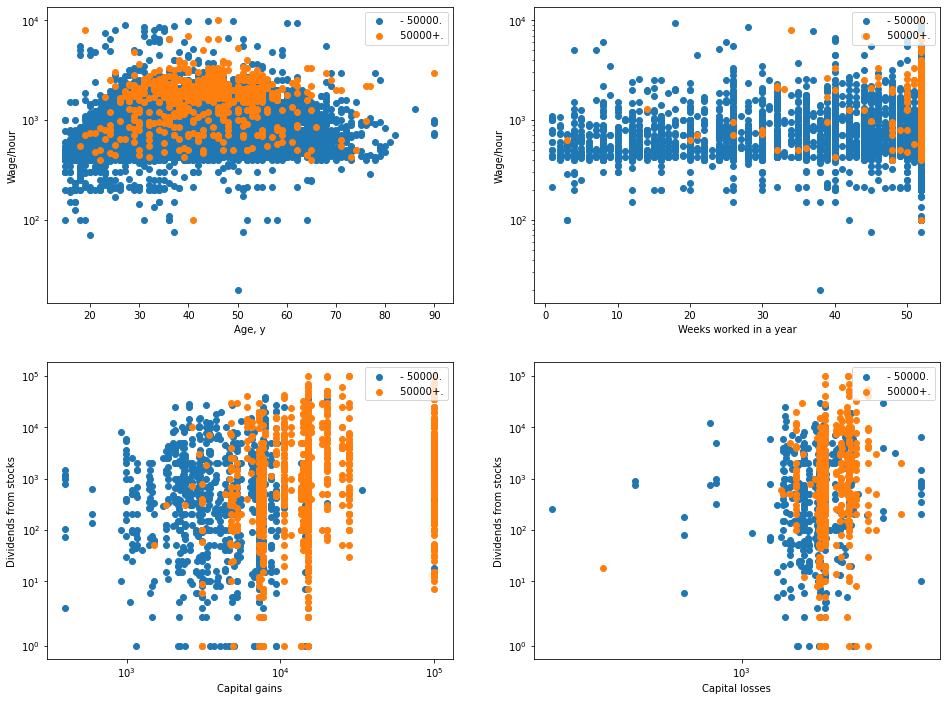

In [34]:
fig = plt.figure(figsize=(16,12))
ax = plt.subplot(2, 2, 1)
for label, pdf in pd_df.groupby(by='income_binary'):
    pdf = pdf.iloc[np.where(pdf['wage_per_hour']!=0)]
    plt.scatter(x=pdf['age'], y=pdf['wage_per_hour'], label=label)
plt.legend(loc=1)
plt.yscale('symlog')
plt.xlabel("Age, y")
plt.ylabel("Wage/hour")

ax = plt.subplot(2, 2, 2)
for label, pdf in pd_df.groupby(by='income_binary'):
    # exclude observations with zeros in any of the variables
    pdf = pdf.iloc[np.where(pdf['wage_per_hour'].mul(pdf['weeks_worked_in_year'])!=0)]
    plt.scatter(x=pdf['weeks_worked_in_year'], y=pdf['wage_per_hour'], label=label)
plt.legend(loc=1)
plt.yscale('log')
plt.xlabel("Weeks worked in a year")
plt.ylabel("Wage/hour")


ax = plt.subplot(2, 2, 3)
for label, pdf in pd_df.groupby(by='income_binary'):
    # exclude observations with zeros in any of the variables
    pdf = pdf.iloc[np.where(pdf['capital_gains'].mul(pdf['dividends_from_stocks'], fill_value=0)!=0.)]
    plt.scatter(x=pdf['capital_gains'], y=pdf['dividends_from_stocks'], label=label)
plt.legend(loc=1)
plt.yscale('symlog')
plt.xscale('symlog')
plt.xlabel("Capital gains")
plt.ylabel("Dividends from stocks")

ax = plt.subplot(2, 2, 4)
for label, pdf in pd_df.groupby(by='income_binary'):
    # exclude observations with zeros in any of the variables
    pdf = pdf.iloc[np.where(pdf['capital_losses'].mul(pdf['dividends_from_stocks'], fill_value=0)!=0.)]
    plt.scatter(x=pdf['capital_losses'], y=pdf['dividends_from_stocks'], label=label)
plt.legend(loc=1)
plt.yscale('symlog')
plt.xscale('symlog')
plt.xlabel("Capital losses")
plt.ylabel("Dividends from stocks")


It seems that from continuous variables the following ones have highest potential in explaining classification above/below 50k.
First, is total capital - as we can see from two graphs at the bottom
* large capital gains, and
* large capital losses,

both seem to positively correlate with being classified 'above 50k'.

Among working population, the proportion of those classified 'above 50k' is highest among those who work full-time (52 weeks/year).

### 1.5.2 Discreet Variables

I might check discreet variables later, after proper feature engineering (e.g., decoding string variables into categorical numeric).

## 1.6 Binary Target Variable

Already exists: `income_binary` in the data we loaded (`df`). Later, I will transform it into a numerical binary variable.

## 1.7 Most Promising Features

I already showed above that among continuous variables, most promising are capital gains (and losses, too, as they both are good proxies for total capital) and working weeks (those who work 52 weeks/year have the highest share of those classified 'above 50k').

For other features, according to Labor Economics (Mincer Equation), the most influential features for working individuals are:
* characteristics that determine human capital:
    - education,
    - age (inversed U-shape),
    - occupation,
    - employment status (full-time or partial employment, self-employed),
* and the set of individual characteristics that affect personal tastes :
    - gender and ethnicity (due to various kinds of discrimination / selection effects), and
    - geographic location (state) and migration status.

## 1.8 When should the raw model dataset be randomly distributed to Train/Test?

Clearly, the data set should be split into tran/dev/test sets **before** any feature engineering. This ensures we do not overfit on the test data because we selected features on the data that already includes the test set. This allows us to be sure that when we deploy model into production, our model performance indicators are as close to the values we are going to see in production, because our model was trained (including the selection of the features) without using the test set.

## 1.9 Feature Engineering

### 1.9.1 Encode strings into numerical variables

In [35]:
str_cols = [c_type[0] for c_type in df.dtypes if 'str' in c_type[1]]
str_cols

['class_of_worker',
 'education',
 'enroll_in_edu_inst_last_wk',
 'marital_stat',
 'major_industry_code',
 'major_occupation_code',
 'race',
 'hispanic_origin',
 'sex',
 'member_of_a_labor_union',
 'reason_for_unemployment',
 'full_or_part_time_employment_stat',
 'tax_filer_stat',
 'region_of_previous_residence',
 'state_of_previous_residence',
 'detailed_household_and_family_stat',
 'detailed_household_summary_in_household',
 'migration_code-change_in_msa',
 'migration_code-change_in_reg',
 'migration_code-move_within_reg',
 'live_in_this_house_1_year_ago',
 'migration_prev_res_in_sunbelt',
 'family_members_under_18',
 'country_of_birth_father',
 'country_of_birth_mother',
 'country_of_birth_self',
 'citizenship',
 'fill_inc_questionnaire_for_veterans_admin',
 'income_binary']

In [36]:
indexed = df  # make a copy of `df`

# in case I want to use SQL queries for feature engineering without One-Hot encoded variables
indexed.createOrReplaceTempView("indexed")

cat_cols = []
for str_ in str_cols:
    cat_ = 'catIndex_' + str_
    indexer = StringIndexer(inputCol=str_, outputCol=cat_)
    indexed = indexer.fit(indexed).transform(indexed)
    cat_cols.append(cat_)

# indexed.show(1)

Let's make a list of indexers to later feed it into a pipeline

In [37]:
indexers = [StringIndexer(inputCol=str_, outputCol='catIndex_' + str_) for str_ in str_cols]

PySpark 3.0 allows you to transform multiple columns at a time.

In [38]:
cat_cols = ['catIndex_' + str_ for str_ in str_cols]

spark3_indexer = StringIndexer(inputCols=str_cols, outputCols=cat_cols)

### 1.9.2 One-Hot Encoding

In [39]:
vec_cols = ['catVec_' + str_ for str_ in str_cols]
encoder = OneHotEncoder(inputCols=cat_cols,
                        outputCols=vec_cols)
model = encoder.fit(indexed)
encoded = model.transform(indexed)

# encoded.show(1)

### 1.9.3 Assembling into Vectors

In [40]:
numeric_features = [col[0] for col in encoded.dtypes if 'string' not in col[1] and 'income_binary' not in col[1]]

assembler = VectorAssembler(
    inputCols=numeric_features,
    outputCol="features")

output = assembler.transform(encoded)
# output.show(1)

I want to use SQL queries for later analysis

In [41]:
output.createOrReplaceTempView("output")

In [42]:
spark.sql("SELECT catIndex_income_binary, count(catIndex_income_binary) from output group by catIndex_income_binary").show()

+----------------------+-----------------------------+
|catIndex_income_binary|count(catIndex_income_binary)|
+----------------------+-----------------------------+
|                   0.0|                       187141|
|                   1.0|                        12382|
+----------------------+-----------------------------+



### 1.9.4 Normalization

I want to use `MinMaxScaler` for all variables (both continuous and dummy variables) to lie between 0 and 1

In [43]:
mmscaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")

## 1.10 Choose a ML Algorithm

I want to use Gradient-Boosted Tree Classifier. Main advantages:
* high accuracy;
* flexible;
* works great with categorical and numerical values.

In [44]:
classifier = GBTClassifier(labelCol='catIndex_income_binary', featuresCol="scaled_features", )

### 1.10.2 Create a Pipeline

In [45]:
gbt_pipeline = Pipeline(stages=[spark3_indexer, encoder, assembler, mmscaler, classifier])

### 1.10.3 Feed All the Data

In [46]:
gbt_model = gbt_pipeline.fit(df)

In [47]:
prediction = gbt_model.transform(df)

In [48]:
prediction.select("prediction", "catIndex_income_binary", "scaled_features").show(5)

+----------+----------------------+--------------------+
|prediction|catIndex_income_binary|     scaled_features|
+----------+----------------------+--------------------+
|       0.0|                   0.0|(411,[0,7,10,12,1...|
|       0.0|                   0.0|(411,[0,1,2,7,8,1...|
|       0.0|                   0.0|(411,[0,7,10,12,1...|
|       0.0|                   0.0|(411,[0,7,14,28,2...|
|       0.0|                   0.0|(411,[0,7,14,28,2...|
+----------+----------------------+--------------------+
only showing top 5 rows



## 1.11 Model Performance Measurements

### 1.11.1 Train Data

Area under ROC

In [49]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol='catIndex_income_binary')
evaluator.evaluate(prediction)

1.0

### 1.11 Test data

In [50]:
df_test = (
    spark.read.format("csv").\
    options(header='false', inferSchema='True').\
    load(os.path.join(DATA_PATH, 'census-income.test.gz')).\
    toDF(*my_cols)
)

Sanity check

In [51]:
df_test.createOrReplaceTempView("df_test")

In [52]:
spark.sql("SELECT income_binary, count(income_binary) from df_test group by income_binary").show()

+-------------+--------------------+
|income_binary|count(income_binary)|
+-------------+--------------------+
|     - 50000.|               93576|
|      50000+.|                6186|
+-------------+--------------------+



In [53]:
test_prediction = gbt_model.transform(df_test)

In [54]:
evaluator.evaluate(test_prediction)

1.0

Satisfied? I am quite.

## 1.12 Steps Taken to Avoid Model Overfitting

None.

It is possible to reduce number of iterations and penalize tree size to prevent overfitting.

In theory, with other classification methods, I would use L1 or L2 regularization, depending on whether we want to select only features that best explain the results or we want to use as many features as possible just to avoid high variance problem.

For neural nets I would use dropout.

## 1.13 What changes do you propose to make this modeling process more effective, if you are to train this in a cluster with 1,000 nodes, 300 million rows and 5,000 features in AWS?

1. I would probably not use Pandas for visualization.
2. Perhaps, I would consider adding ETL stage, to store data in `parquet` format.
3. Spark is created to be scalable, so no changes are needed in the training/prediction part. *MAYBE*, the initialization would be different - to run it on a cluster.

I never worked with AWS, so I don't know what else is needed. In Watson Studio (the only cloud service that I am familiar with) all you need is to select an appropriate environment - that's it.

In [55]:
spark.stop()

In [56]:
print(f"Elapsed time: {time.time() - t0}s")

Elapsed time: 416.0305063724518s
